In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from utils.code_exercise1 import my_window, get_fundamental_freq
from utils.code_exercise2 import compute_stft, plot_spectrum
from scipy.signal import get_window
import sounddevice

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
y, sr = librosa.core.load("data/exercise6/SpeechBabble.wav", sr=None)

In [3]:
frame_length = 32
frame_shift = 16
n_length = int(sr * frame_length / 1000) 
hann_win = get_window('hann', n_length)
sqrt_hann_win = np.sqrt(hann_win)

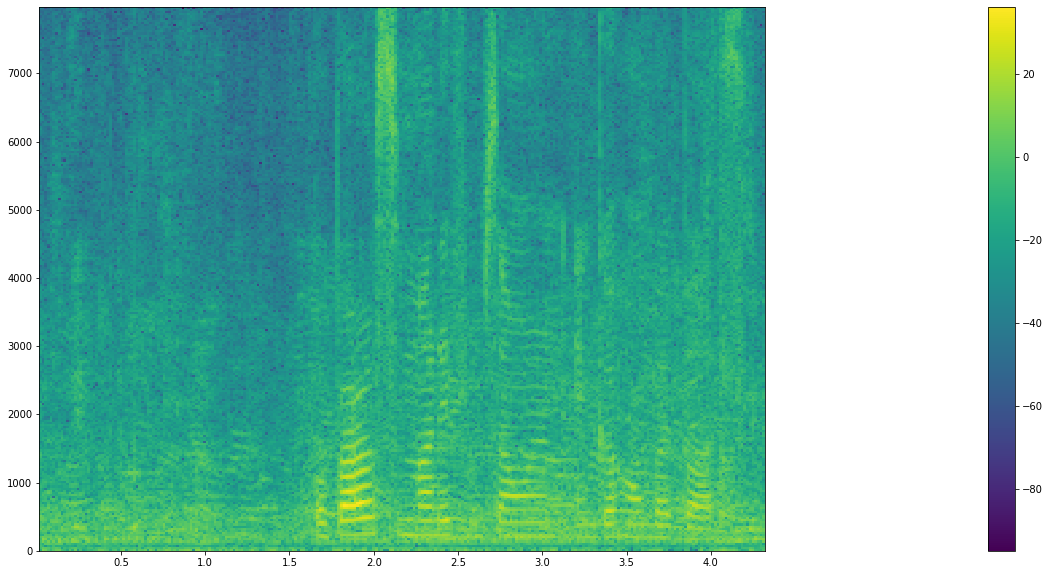

In [4]:
m_stft, v_freq, v_time = compute_stft(y, sr, frame_length, frame_shift, sqrt_hann_win)
plot_spectrum(m_stft, v_freq, v_time)

In [5]:
def to_db(m_stft):
    return 10 * np.log10(np.maximum(np.square(np.abs(m_stft)), 10**( -15)))

theta = 15
def compute_p_h1(Y, N_psd):
    return 1 / (1 + (1+theta) * np.exp(-(np.power(Y,2)/N_psd * theta / (1+theta))))

In [6]:
Y = to_db(m_stft)

In [7]:
Y.shape

(270, 257)

In [8]:
Q = np.zeros(Y.shape)
P_h1 = np.zeros(Y.shape)
N_period = np.zeros(Y.shape)
N_psd = np.zeros(Y.shape)

In [9]:
N_psd[0] = np.sum(np.power(Y[:5], 2))/ 5.0
Q[0] = np.zeros(Y.shape[1])

In [10]:
for l in range(1, v_time.shape[0]):

    P_h1[l] = compute_p_h1(Y[l], N_psd[l-1])
    Q[l] = 0.9 * Q[l-1] + 0.1 * P_h1[l]
    idx = np.where(Q[l] > 0.99)

    for k in idx[0]:
        P_h1[l][k] = min(0.99, P_h1[l][k])

    N_period[l] = P_h1[l] * N_psd[l-1] + (1-P_h1[l]) * np.power(Y[l], 2)
    N_psd[l] = 0.8 * N_psd[l-1] + 0.2 * N_period[l]

     

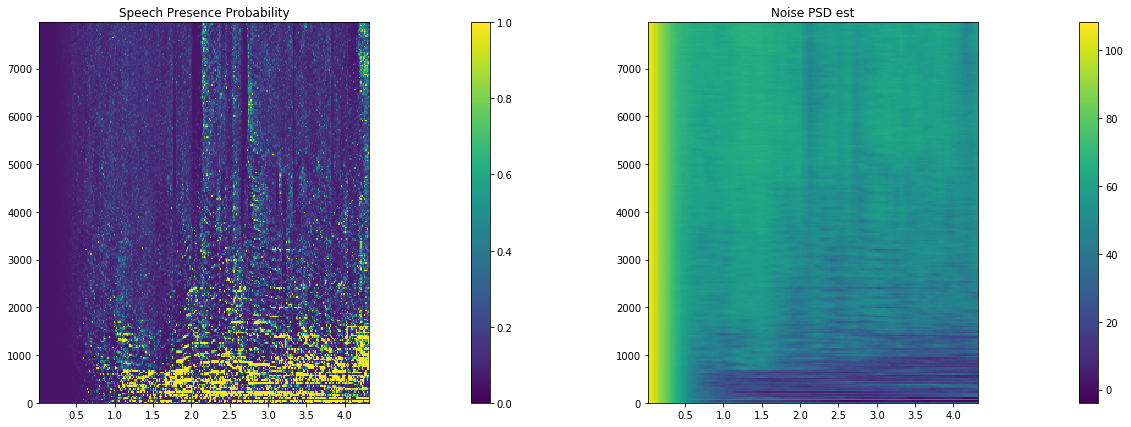

In [11]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121)
ax.set_title("Speech Presence Probability")

im = ax.imshow(P_h1.T,
                cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                v_freq [ -1]] , aspect ='auto')
fig.colorbar(im , orientation ="vertical", pad =0.2)

ax = fig.add_subplot(122)
ax.set_title("Noise PSD est")
im = ax.imshow(to_db(N_psd).T,
                cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                v_freq [ -1]] , aspect ='auto')
fig.colorbar(im , orientation ="vertical", pad =0.2)

In [12]:
fig.show()

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.
